In [1]:
import uproot
import uproot_methods
import awkward
import matplotlib.pyplot as plt
import numpy as np
import time
import glob
import concurrent.futures
import json

In [2]:

# Make 4 parallel threads
executor = concurrent.futures.ThreadPoolExecutor(4)

# Make a cache for uproot
cache = {}

In [3]:
# Get the sample metadata
samples = json.load( open('samples_dy.json') )


In [4]:
#cache1 = {}
#Ttest = uproot.open('/mnt/cms-data/store/group/lpctlbsm/NanoAODJMAR_2019_V1/Production/CRAB/DYJetsToLL_M-50_HT-800to1200_TuneCP5_13TeV-madgraphMLM-pythia8/DYJetsToLLM-50HT-800to1200TuneCP513TeV-madgraphMLM-pythia8RunIIFall17MiniAODv2-PU2017/190312_200548/0000/nano102x_on_mini94x_2017_mc_NANO_9.root')['Events']
#Ttest.arrays("*",cache=cache1)

In [8]:

jet_names = [b'FatJet_pt', b'FatJet_eta', b'FatJet_phi', b'FatJet_mass']
gen_names = [b'GenJetAK8_pt', b'GenJetAK8_eta', b'GenJetAK8_phi', b'GenJetAK8_mass']
#T = uproot.open("/uscms/home/rappocc/nobackup/analysis/B2G/CMSSW_10_2_9/src/Analysis/TTbarAllHad/test/QCD_Pt-15to7000_TuneCP5_Flat_13TeV_pythia8_RunIIFall17NanoAODv4_example.root")["Events"]
rbins = [i * 0.01 for i in range(300)]
ptbins = [170,200,250,300,350,400,500,600,700,800,900,1000]
mbins = [0,5,10,15,20,25,30,35,40,50,60,70,80,90,100,150,300,1000]
print("ptbins, mbins =", len(ptbins), len(mbins))
hists = []

start_time = time.perf_counter()
nev = 0

prefix = '/mnt/cms-data/store/group/lpctlbsm/NanoAODJMAR_2019_V1/Production/CRAB/'

for sample in samples["samples"]:    
    name, xsec, nevents = sample['name'], sample['xsec'], sample['nevents']
    files = glob.glob(prefix + name + '/*/*/*/*.root')
    
    weight = xsec / nevents
    print ("processing sample: ", sample )

    for T in uproot.iterate(files, 'Events', jet_names + gen_names, cache=cache,
                            entrysteps=500000,executor=executor):

        Jet_pt,Jet_eta,Jet_phi,Jet_mass = [ T.pop(i) for i in jet_names]
        GenJet_pt,GenJet_eta,GenJet_phi,GenJet_mass = [ T.pop(i) for i in gen_names]
        print('.',end='')
        #print(nev)
        
        jets = uproot_methods.TLorentzVectorArray.from_ptetaphim(Jet_pt, Jet_eta, Jet_phi, Jet_mass)
        genjets = uproot_methods.TLorentzVectorArray.from_ptetaphim(GenJet_pt, GenJet_eta, GenJet_phi, GenJet_mass)

        onejet = jets.counts > 0
        onegen = genjets.counts > 0
        goodjets_index = (jets.pt > 170.)
        goodgens_index = (genjets.pt > 50.)
        goodjets = jets[onejet & onegen & goodjets_index]
        goodgens = genjets[onejet & onegen & goodgens_index]        
        pairing = goodjets.cross(goodgens, nested=True)
        
        metric = pairing.i1.delta_r(pairing.i0)
        if metric.size > 0:        
            index_of_minimized = metric.argmin()
        
        passes_cut = (metric[index_of_minimized] < 0.4)
        best_pairings_that_pass_cut = pairing[index_of_minimized][passes_cut]
        genrecos = best_pairings_that_pass_cut.flatten(axis=1)

        ptresponse = genrecos.i0.pt / genrecos.i1.pt
        vals = np.array([genrecos.i1.pt.flatten(),
                           genrecos.i1.mass.flatten(),
                           genrecos.i0.pt.flatten(),
                           genrecos.i0.mass.flatten()
                          ]
                         )
        
        weights = np.full( vals[0].shape, weight )
        bins = (ptbins,mbins,ptbins,mbins)
        H,edges=np.histogramdd( vals.T, 
                               bins=bins, weights=weights)
        hists.append(H)
        nev += 1
    
cpu_time = time.perf_counter() - start_time
print ('Processing time: ', cpu_time, ',  nev: ', nev) 

ptbins, mbins = 12 18
processing sample:  {'name': 'DYJetsToLL_M-50_HT-70to100_TuneCP5_13TeV-madgraphMLM-pythia8', 'xsec': 143.0, 'nevents': 9344037.0}
...............................

TypeError: jagged index must be boolean (mask) or integer (fancy indexing)

In [5]:
# Set fonts (from https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot)
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [6]:
H2 = H.reshape( (len(ptbins)-1)*(len(mbins)-1), (len(ptbins)-1)*(len(mbins)-1) )

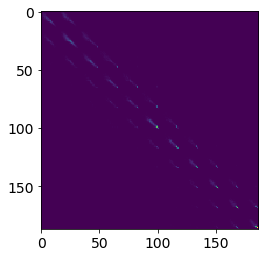

In [7]:
plt.imshow(H2)